In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
from category_encoders import TargetEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin


In [5]:
# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler('training.log')

# Create formatters and add them to the handlers
console_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_format = logging.Formatter('%(asctime)s - %(name)s - %(levellevel)s - %(message)s')
console_handler.setFormatter(console_format)
file_handler.setFormatter(file_format)

# Add handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)


In [6]:
# Load datasets
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_train.csv")
test_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_test.csv")

# Drop ID column from training and test data
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")

# Split the data into training and validation sets before preprocessing
X = train_df.drop(columns=['Response'])
y = train_df['Response']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

logger.info(f"Training set shape: {X_train.shape}")
logger.info(f"Validation set shape: {X_val.shape}")


2024-07-13 18:08:02,975 - __main__ - INFO - Train dataset shape: (11465233, 11)
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 464, in format
    return self._format(record)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 460, in _format
    return self._fmt % values
           ~~~~~~~~~~^~~~~~~~
KeyError: 'levellevel'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 706, in format
    s = sel

In [7]:
# Define custom transformers
class InteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Age_Annual_Premium'] = X['Age'] * X['Annual_Premium']
        X['Age_Vintage'] = X['Age'] * X['Vintage']
        X['Annual_Premium_Vintage'] = X['Annual_Premium'] * X['Vintage']
        X['Age_Region_Code'] = X['Age'] * X['Region_Code']
        X['Vintage_Region_Code'] = X['Vintage'] * X['Region_Code']
        X['Annual_Premium_Region_Code'] = X['Annual_Premium'] * X['Region_Code']
        return X

class TargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = TargetEncoder(cols=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])
    
    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self
    
    def transform(self, X):
        return self.encoder.transform(X)

class PolynomialFeatureGeneration(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    
    def fit(self, X, y=None):
        self.poly.fit(X[['Age', 'Annual_Premium', 'Vintage']])
        return self
    
    def transform(self, X):
        poly_features = self.poly.transform(X[['Age', 'Annual_Premium', 'Vintage']])
        poly_feature_names = self.poly.get_feature_names_out(['Age', 'Annual_Premium', 'Vintage'])
        poly_df = pd.DataFrame(poly_features, columns=[f'poly_{name.replace(" ", "_")}' for name in poly_feature_names], index=X.index)
        X = pd.concat([X, poly_df], axis=1)
        return X


In [8]:
# Define the pipeline
pipeline = Pipeline([
    ('interactions', InteractionFeatures()),
    ('target_encoding', TargetEncoding()),
    ('poly_features', PolynomialFeatureGeneration()),
    ('scaling', StandardScaler())
])

# Apply the preprocessing pipeline
X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = pipeline.transform(X_val)

# Handle imbalanced data using SMOTE on the training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

logger.info(f"Training data resampled using SMOTE. New shape: {X_train_resampled.shape}")


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arra

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
from category_encoders import TargetEncoder
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# # Save the transformed datasets to CSV
# pd.DataFrame(X_train_resampled).to_csv('X_train_transformed.csv', index=False)
# pd.DataFrame(X_val_preprocessed).to_csv('X_val_transformed.csv', index=False)
# pd.DataFrame(y_train_resampled).to_csv('y_train_transformed.csv', index=False)
# pd.DataFrame(y_val).to_csv('y_val_transformed.csv', index=False)

# logger.info("Transformed datasets saved to CSV files")

#If needed, load the transformed datasets from CSV
X_train_resampled = pd.read_csv('X_train_transformed.csv')
X_val_preprocessed = pd.read_csv('X_val_transformed.csv')
y_train_resampled = pd.read_csv('y_train_transformed.csv')
y_val = pd.read_csv('y_val_transformed.csv')


In [4]:
def run_random_search(X_train, y_train):
    # Define the parameter grid
    param_dist = {
        'learning_rate': np.linspace(0.03, 0.1, 10),
        'num_leaves': np.arange(60, 121, 10),
        'max_depth': np.arange(10, 16),
        'min_data_in_leaf': np.arange(10, 51, 10),
        'bagging_fraction': np.linspace(0.6, 0.8, 5),
        'feature_fraction': np.linspace(0.6, 0.8, 5),
        'lambda_l1': np.linspace(0.0, 1.0, 5),
        'lambda_l2': np.linspace(0.0, 1.0, 5),
        'bagging_freq': np.arange(1, 8)
    }

    # Initialize the LightGBM classifier
    lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc')

    # Define the scoring function
    scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_dist,
        n_iter=5,  # Increase number of iterations for better search
        scoring=scorer,
        cv=3,  # 3-fold cross-validation
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

# Run RandomizedSearchCV
best_model, best_params, best_score = run_random_search(X_train_resampled, y_train_resampled)

logger.info(f"Best AUC: {best_score}")
logger.info(f"Best parameters: {best_params}")

# Save the best trial parameters
pd.DataFrame([best_params]).to_csv('best_params_randomsearch.csv', index=False)

# Load the best parameters from the saved file (if needed)
best_params_loaded = pd.read_csv('best_params_randomsearch.csv').to_dict(orient='records')[0]

# Optionally, you can refit the model on the entire training set using the best parameters
best_model_retrained = lgb.LGBMClassifier(**best_params_loaded)
best_model_retrained.fit(X_train_resampled, y_train_resampled)


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Evaluate the best model on the training set
    train_preds = model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)

    # Evaluate the best model on the validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)

    logger.info(f"Training AUC with best parameters: {train_auc}")
    logger.info(f"Validation AUC with best parameters: {val_auc}")

    # Check for overfitting
    overfit_threshold = 0.05  # Adjust the threshold as needed
    overfit_metric = abs(train_auc - val_auc)
    if overfit_metric > overfit_threshold:
        logger.warning(f"Overfitting detected: Train AUC - {train_auc}, Val AUC - {val_auc}, Difference - {overfit_metric}")
    else:
        logger.info(f"No overfitting detected: Train AUC - {train_auc}, Val AUC - {val_auc}, Difference - {overfit_metric}")

    return train_auc, val_auc

# Evaluate the best model
train_auc, val_auc = evaluate_model(best_model_retrained, X_train_resampled, y_train_resampled, X_val_preprocessed, y_val)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25
[LightGBM] [Warning] lambda_l2 is set=0.75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.25, reg_alpha=0.0 will be igno

2024-07-13 18:31:39,260 - __main__ - INFO - Training AUC with best parameters: 0.9540466333804721
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 464, in format
    return self._format(record)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 460, in _format
    return self._fmt % values
           ~~~~~~~~~~^~~~~~~~
KeyError: 'levellevel'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 706, in 

In [ ]:
def train_final_model(params, X_train, y_train, X_val, y_val):
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)

    # Define the early stopping callback
    early_stopping_callback = lgb.early_stopping(stopping_rounds=20, first_metric_only=True, verbose=True)

    # Train the LightGBM model with the best parameters
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[train_data, val_data],
        callbacks=[early_stopping_callback],
    )

    return model

# Train the final model
final_model = train_final_model(best_params_loaded, X_train_resampled, y_train_resampled, X_val_preprocessed, y_val)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.438236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4362
[LightGBM] [Info] Number of data points in the train set: 16086232, number of used features: 21
[LightGBM] [Info] Start training from score 0.500000
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0889488	valid_1's l2: 0.115149
Evaluated only: l2


2024-07-13 18:35:53,575 - __main__ - INFO - Final Train AUC: 0.9554935663397268
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 464, in format
    return self._format(record)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 460, in _format
    return self._fmt % values
           ~~~~~~~~~~^~~~~~~~
KeyError: 'levellevel'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 706, in format
    s = sel

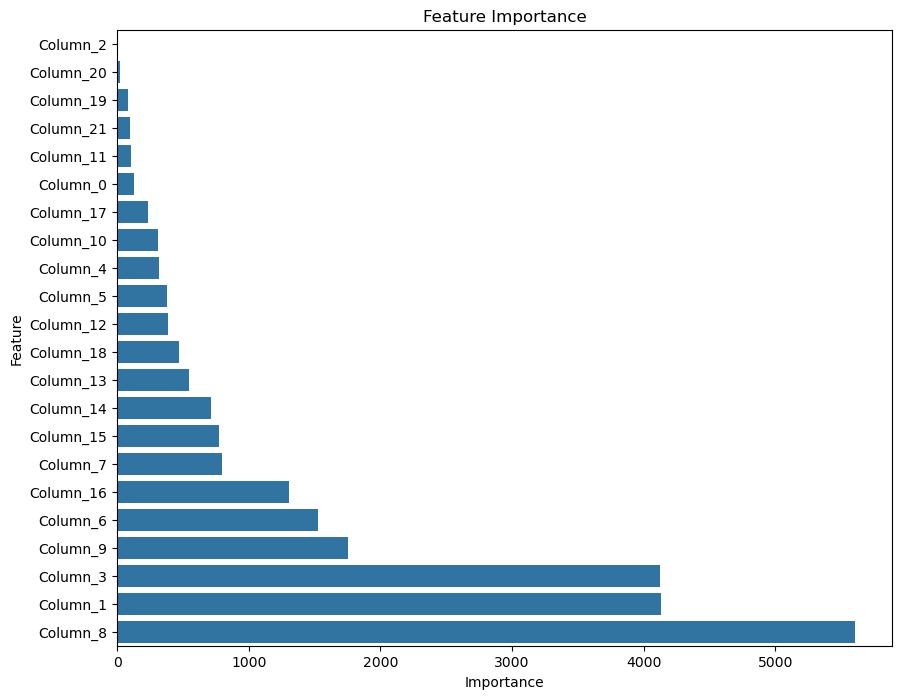

2024-07-13 18:35:53,994 - __main__ - INFO - Model saved as lightgbm_model_best.pkl
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 464, in format
    return self._format(record)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 460, in _format
    return self._fmt % values
           ~~~~~~~~~~^~~~~~~~
KeyError: 'levellevel'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\logging\__init__.py", line 706, in format
    s = 

In [ ]:
def save_model_and_metrics(model, train_auc, val_auc):
    # Predict on train and validation set
    y_train_pred = model.predict(X_train_resampled, num_iteration=model.best_iteration)
    y_val_pred = model.predict(X_val_preprocessed, num_iteration=model.best_iteration)

    # Evaluation metrics
    train_auc = roc_auc_score(y_train_resampled, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    logger.info(f"Final Train AUC: {train_auc}")
    logger.info(f"Final Validation AUC: {val_auc}")

    # Feature Importance
    importance = model.feature_importance(importance_type='split')
    feature_names = model.feature_name()

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Save feature importance to CSV
    feature_importance_df.to_csv("feature_importance.csv", index=False)
    logger.info("Feature importance saved as feature_importance.csv")

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.savefig("feature_importance.png")
    logger.info("Feature importance plot saved as feature_importance.png")

    plt.show()

    # Save the model and metrics
    joblib.dump(model, "lightgbm_model_best.pkl")
    logger.info("Model saved as lightgbm_model_best.pkl")

    # Save the metrics to a CSV file
    metrics = {
        "train_auc": train_auc,
        "val_auc": val_auc
    }

    metrics_df = pd.DataFrame(metrics, index=[0])
    metrics_df.to_csv("model_metrics.csv", index=False)
    logger.info("Model metrics saved as model_metrics.csv")

    # Final log message
    logger.info("Training and evaluation process completed successfully.")

# Save the model and metrics
save_model_and_metrics(final_model, train_auc, val_auc)
